<a href="https://colab.research.google.com/github/MahdieRah/Designing-AMPs-Using-Machine-Learning/blob/main/AMP_Design_with_ProtGPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"""
AMP Generator Script for Google Colab
-------------------------------------
- Uses ProtGPT2 to generate candidate antimicrobial peptides (AMPs)
- Filters candidates based on physicochemical constraints
- Supports batch generation
- Saves valid results to CSV
- Plots basic statistics

Install dependencies:
!pip install transformers biopython matplotlib pandas
"""

In [4]:
!pip install transformers biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 53.2 MB/s eta 0:00:00


In [5]:

import torch
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from Bio.SeqUtils import ProtParam

In [11]:
class AMPGenerator:
    def __init__(self, model_name="nferruz/ProtGPT2", device=None, seed_sequences=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(model_name).to(self.device)

        self.seed_sequences=["KRK", "LLKK", "GIGKFL", "RWK", "RRWW", "WKWK", "FFRW"]


    def is_valid_amp(self, peptide: str) -> bool:
        peptide = re.sub(r"[^A-Z]", "", peptide.upper())
        if not 10 <= len(peptide) <= 40: ...
        if net_charge < 1: ...
        0.5 < gravy < 2.0  # instead of 0.8–1.8

        basic = peptide.count('K') + peptide.count('R')
        acidic = peptide.count('D') + peptide.count('E')
        net_charge = basic - acidic
        if net_charge < 2:
            return False

        try:
            analysis = ProtParam.ProteinAnalysis(peptide)
            gravy = analysis.gravy()
            return (
                0.8 < gravy < 1.8 and
                peptide.count("P") < 2 and
                peptide.count("C") < 2
            )
        except Exception:
            return False

    def analyze_peptide(self, peptide: str) -> dict:
        analysis = ProtParam.ProteinAnalysis(peptide)
        return {
            "Peptide": peptide,
            "Length": len(peptide),
            "Charge@pH7": round(analysis.charge_at_pH(7), 1),
            "GRAVY": round(analysis.gravy(), 2),
            "pI": round(analysis.isoelectric_point(), 2)
        }

    def generate_peptide(self, seed: str, max_length=25) -> str:
        input_ids = self.tokenizer.encode(seed, return_tensors="pt").to(self.device)
        attention_mask = input_ids.ne(self.tokenizer.pad_token_id)

        output = self.model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            do_sample=True,
            temperature=0.85,
            top_k=8,
            repetition_penalty=1.4,
            pad_token_id=self.tokenizer.eos_token_id
        )

        decoded = self.tokenizer.decode(output[0], skip_special_tokens=True)
        return re.sub(r"[^A-Z]", "", decoded.upper())

    def batch_generate(self, max_attempts=100, save_path="valid_peptides.csv"):
        print(f"\n🔁 Starting batch AMP generation (max {max_attempts} attempts)...")
        start_time = time.time()

        seen = set()
        valid_peptides = []

        for attempt in range(1, max_attempts + 1):
            seed = self.seed_sequences[attempt % len(self.seed_sequences)]
            candidate = self.generate_peptide(seed)

            if candidate in seen:
                continue
            seen.add(candidate)

            if self.is_valid_amp(candidate):
                print(f"✅ [{attempt}] {candidate}")
                valid_peptides.append(self.analyze_peptide(candidate))

        if not valid_peptides:
            print("\n⚠️ No valid peptides found.")
            return None

        df = pd.DataFrame(valid_peptides)
        df.to_csv(save_path, index=False)
        elapsed = time.time() - start_time

        print(f"\n✅ Saved {len(df)} valid peptides in {elapsed:.1f} seconds to '{save_path}'")
        self.plot_stats(df)
        return df

    def plot_stats(self, df):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.hist(df['GRAVY'], bins=10, color='skyblue', edgecolor='black')
        plt.title('GRAVY Score Distribution')
        plt.xlabel('GRAVY')
        plt.ylabel('Count')

        plt.subplot(1, 2, 2)
        plt.hist(df['Charge@pH7'], bins=10, color='salmon', edgecolor='black')
        plt.title('Net Charge at pH 7')
        plt.xlabel('Charge')
        plt.ylabel('Count')

        plt.tight_layout()
        plt.show()

# Example usage in Colab
if __name__ == "__main__":
    generator = AMPGenerator()
    results = generator.batch_generate(max_attempts=200)  # adjust as needed


Using device: cuda

🔁 Starting batch AMP generation (max 200 attempts)...


UnboundLocalError: cannot access local variable 'net_charge' where it is not associated with a value

Using device: cuda

🔁 Starting batch AMP generation (max 1000 attempts)...
✅ [9] GIGKFLVDKF
✅ [44] GIGKFLKKHKDEIISGLIVIGIVVTIVGLVI
✅ [50] LLKKGSRLII
✅ [51] GIGKFLGERLPTIYKYVYIPIWVFIGLVIYLFI
✅ [65] GIGKFLGSFFAILLLFGIWILVMKYIYKWY
✅ [170] GIGKFLSSICNS
✅ [191] GIGKFLGGYI
✅ [331] GIGKFLGGALGGLGALVGL
✅ [359] GIGKFLGSFS
✅ [370] FFRWFLPWVI
✅ [384] FFRWFLPLLILLPLALGAF
✅ [447] FFRWISLILLILWLIKFIFYLFKKKN
✅ [457] GIGKFLGGLLGKGKAA
✅ [464] GIGKFLGGLLLFFAIWLFY
✅ [471] GIGKFLGSFFTF
✅ [513] GIGKFLSSLLLAILLSFSMGFFAYVY
✅ [615] FFRWSLISLILIW
✅ [618] GIGKFLSSFIWGIISDKVGRRKVILLGLL
✅ [650] FFRWIGWLPF
✅ [727] FFRWGLVVLAVLVALAVWLWGTR
✅ [884] GIGKFLSSMS
✅ [905] GIGKFLGGIYVS
✅ [940] GIGKFLKNYFKYRFIYFFIFLIIILLFIFENI
✅ [965] FFRWSSFHLL

✅ Saved 24 valid peptides in 209.4 seconds to 'valid_peptides.csv'


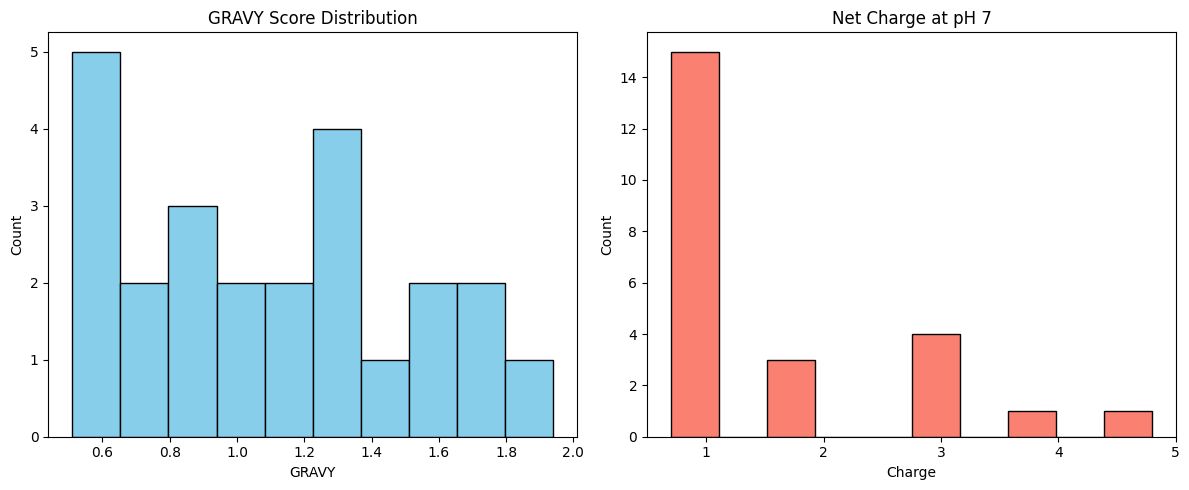

In [12]:
class AMPGenerator:
    def __init__(self, model_name="nferruz/ProtGPT2", device=None, seed_sequences=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(model_name).to(self.device)

        self.seed_sequences = seed_sequences or ["KRK", "LLKK", "GIGKFL", "RWK", "RRWW", "WKWK", "FFRW"]

    def is_valid_amp(self, peptide: str) -> bool:
        peptide = re.sub(r"[^A-Z]", "", peptide.upper())

        if not 10 <= len(peptide) <= 40:
            return False

        basic = peptide.count('K') + peptide.count('R')
        acidic = peptide.count('D') + peptide.count('E')
        net_charge = basic - acidic
        if net_charge < 1:
            return False

        try:
            analysis = ProtParam.ProteinAnalysis(peptide)
            gravy = analysis.gravy()
            return (
                0.5 < gravy < 2.0 and
                peptide.count("P") < 3 and
                peptide.count("C") < 3
            )
        except Exception:
            return False

    def analyze_peptide(self, peptide: str) -> dict:
        analysis = ProtParam.ProteinAnalysis(peptide)
        return {
            "Peptide": peptide,
            "Length": len(peptide),
            "Charge@pH7": round(analysis.charge_at_pH(7), 1),
            "GRAVY": round(analysis.gravy(), 2),
            "pI": round(analysis.isoelectric_point(), 2)
        }

    def generate_peptide(self, seed: str, max_length=25) -> str:
        input_ids = self.tokenizer.encode(seed, return_tensors="pt").to(self.device)
        attention_mask = input_ids.ne(self.tokenizer.pad_token_id)

        output = self.model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            do_sample=True,
            temperature=1.0,
            top_k=20,
            repetition_penalty=1.4,
            pad_token_id=self.tokenizer.eos_token_id
        )

        decoded = self.tokenizer.decode(output[0], skip_special_tokens=True)
        return re.sub(r"[^A-Z]", "", decoded.upper())

    def batch_generate(self, max_attempts=100, save_path="valid_peptides.csv"):
        print(f"\n🔁 Starting batch AMP generation (max {max_attempts} attempts)...")
        start_time = time.time()

        seen = set()
        valid_peptides = []

        for attempt in range(1, max_attempts + 1):
            seed = self.seed_sequences[attempt % len(self.seed_sequences)]
            candidate = self.generate_peptide(seed)

            if candidate in seen:
                continue
            seen.add(candidate)

            if self.is_valid_amp(candidate):
                print(f"✅ [{attempt}] {candidate}")
                valid_peptides.append(self.analyze_peptide(candidate))

        if not valid_peptides:
            print("\n⚠️ No valid peptides found.")
            return None

        df = pd.DataFrame(valid_peptides)
        df.to_csv(save_path, index=False)
        elapsed = time.time() - start_time

        print(f"\n✅ Saved {len(df)} valid peptides in {elapsed:.1f} seconds to '{save_path}'")
        self.plot_stats(df)
        return df

    def plot_stats(self, df):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.hist(df['GRAVY'], bins=10, color='skyblue', edgecolor='black')
        plt.title('GRAVY Score Distribution')
        plt.xlabel('GRAVY')
        plt.ylabel('Count')

        plt.subplot(1, 2, 2)
        plt.hist(df['Charge@pH7'], bins=10, color='salmon', edgecolor='black')
        plt.title('Net Charge at pH 7')
        plt.xlabel('Charge')
        plt.ylabel('Count')

        plt.tight_layout()
        plt.show()


# Example usage in Colab
if __name__ == "__main__":
    generator = AMPGenerator()
    results = generator.batch_generate(max_attempts=1000)  # increase attempts for better yield

In [13]:
from google.colab import files
files.download('valid_peptides.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>